# 5-gestures model

In [1]:
import os
from pathlib import Path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from dataset import Dataset
from model import Model
from evaluator import Evaluator

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load the data

In [4]:
SPLIT_THRESHOLD = 0.2
BATCH_SIZE = 32
SEED = 42

In [5]:
tf.random.set_seed(SEED)

In [6]:
data = Dataset(split_threshold=SPLIT_THRESHOLD, batch_size=BATCH_SIZE, path=Path('data/asl_classic/asl_classic'), seed=SEED)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [7]:
desired_classes = ['C', 'G', 'H', 'nothing', 'Q', 'space']
data.select_classes(desired_classes)

In [8]:
images, _ = next(iter(data.train))
assert images.numpy().min() == 0
assert images.numpy().max() == 255
assert images.shape == (32, 256, 256, 3)

## Pre-processing

In [9]:
data.preprocess(resize=True, crop=True)

In [10]:
images, _ = next(iter(data.train))
assert images.numpy().min() == 0
assert images.numpy().max() == 255
assert images.shape == (32, 96, 96, 3)

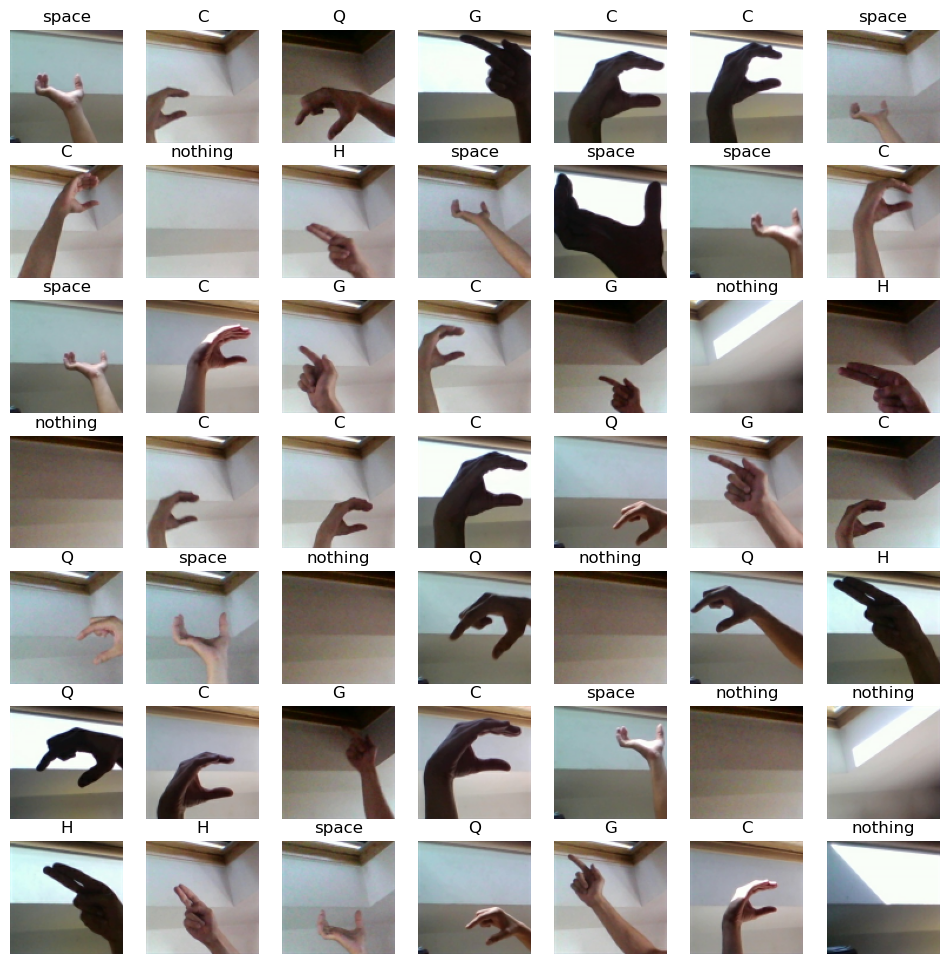

In [11]:
data.visualize_images('train', num_images=7)

In [12]:
data.plot_class_distribution('train', 3000)

In [13]:
data.plot_class_distribution('validation', 3000)

In [14]:
data.rescale()

In [15]:
images, _ = next(iter(data.train))
assert images.numpy().min() == -1
assert images.numpy().max() == 1
assert images.shape == (32, 96, 96, 3)

In [16]:
data.cache()

## Train the model

In [17]:
model = Model(num_classes=len(data.class_labels))

In [18]:
model.compile(learning_rate=1e-3)
model.fit(data.train, data.train, epochs=20, log_dir=Path('logs'))

Epoch 1/20
448/448 [==============================] - 51s 20ms/step - loss: 0.1586 - accuracy: 0.9513 - val_loss: 0.0052 - val_accuracy: 0.9987
Epoch 2/20
448/448 [==============================] - 6s 13ms/step - loss: 0.0146 - accuracy: 0.9953 - val_loss: 0.0016 - val_accuracy: 0.9998
Epoch 3/20
448/448 [==============================] - 5s 12ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0014 - val_accuracy: 0.9997
Epoch 4/20
448/448 [==============================] - 5s 11ms/step - loss: 0.0107 - accuracy: 0.9966 - val_loss: 7.8947e-04 - val_accuracy: 0.9999
Epoch 5/20
448/448 [==============================] - 4s 10ms/step - loss: 0.0069 - accuracy: 0.9976 - val_loss: 9.6697e-04 - val_accuracy: 0.9999
Epoch 6/20
448/448 [==============================] - 4s 10ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.0024 - val_accuracy: 0.9993
Epoch 7/20
448/448 [==============================] - 4s 10ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 4.0266e-04 - val_acc

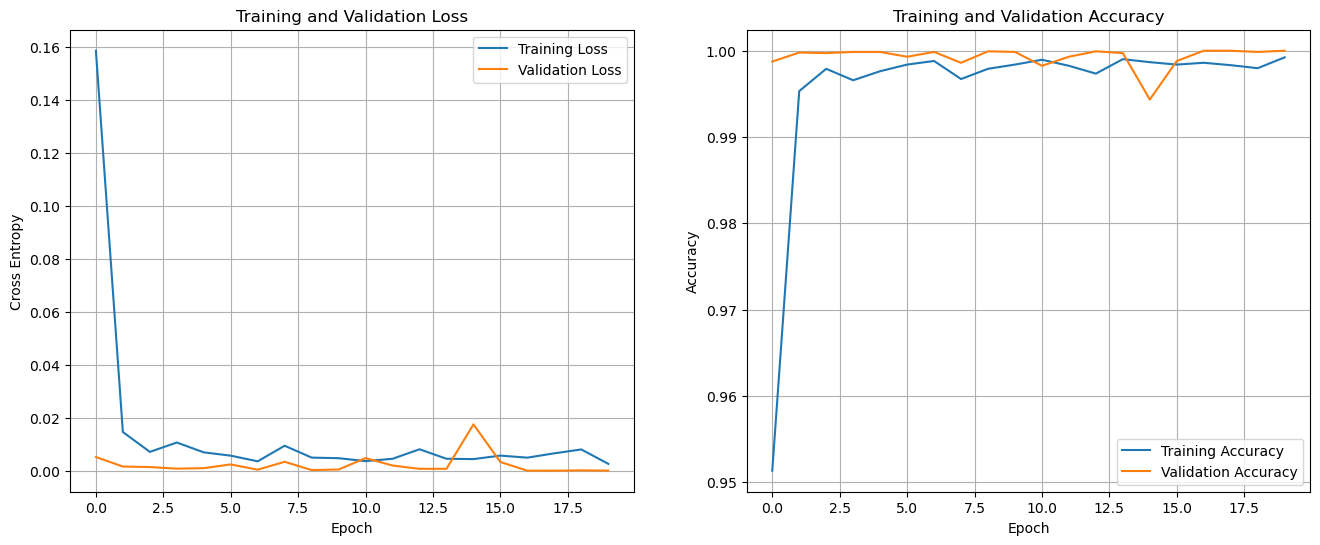

In [19]:
model.plot_history('fit')

In [20]:
model.plot_model(dpi=800);

In [21]:
model.fine_tune(data.train, data.train, epochs=20, learning_rate=1e-5, log_dir=Path('logs'))

Epoch 1/20
448/448 [==============================] - 17s 18ms/step - loss: 0.7082 - accuracy: 0.9171 - val_loss: 0.0448 - val_accuracy: 0.9900
Epoch 2/20
448/448 [==============================] - 6s 14ms/step - loss: 0.1796 - accuracy: 0.9726 - val_loss: 0.0205 - val_accuracy: 0.9954
Epoch 3/20
448/448 [==============================] - 6s 14ms/step - loss: 0.1122 - accuracy: 0.9813 - val_loss: 0.0091 - val_accuracy: 0.9977
Epoch 4/20
448/448 [==============================] - 6s 14ms/step - loss: 0.0772 - accuracy: 0.9855 - val_loss: 0.0040 - val_accuracy: 0.9987
Epoch 5/20
448/448 [==============================] - 6s 14ms/step - loss: 0.0493 - accuracy: 0.9904 - val_loss: 0.0027 - val_accuracy: 0.9994
Epoch 6/20
448/448 [==============================] - 6s 14ms/step - loss: 0.0403 - accuracy: 0.9909 - val_loss: 0.0013 - val_accuracy: 0.9997
Epoch 7/20
448/448 [==============================] - 6s 14ms/step - loss: 0.0279 - accuracy: 0.9943 - val_loss: 0.0011 - val_accuracy: 0.999

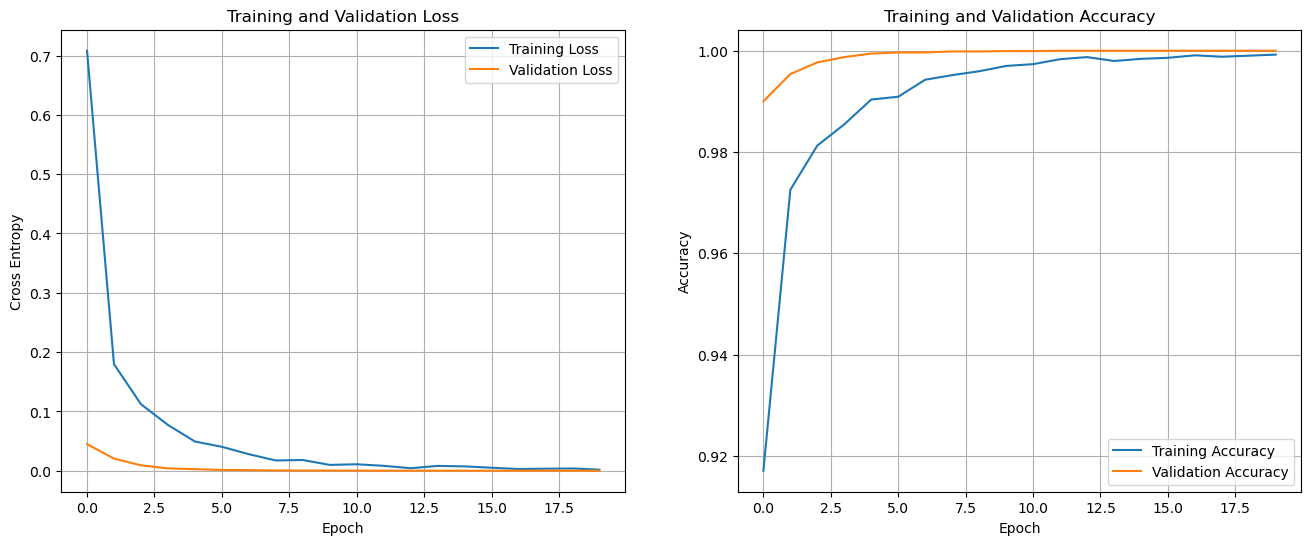

In [22]:
model.plot_history('fine_tuning')

In [24]:
model.save(Path('models/5-gestures'))

INFO:tensorflow:Assets written to: models/5-gestures/asl_mobilenet_tuned/assets


INFO:tensorflow:Assets written to: models/5-gestures/asl_mobilenet_tuned/assets


## Evaluation on the validation set

In [25]:
valid_evaluator = Evaluator(model.model, data.validation, data.class_labels)

116it [00:05, 23.02it/s]


In [26]:
valid_evaluator.evaluate()

Loss function: 0.029
Accuracy: 99.92%


In [34]:
valid_evaluator.confusion_matrix(size=800, save_path='figures/5_cm.png')

In [35]:
valid_evaluator.relative_errors(save_path='figures/5_errors.png')

## Quantization and evaluation

In [29]:
model.quantize(data.train, Path('models'))

INFO:tensorflow:Assets written to: temp/model/assets


INFO:tensorflow:Assets written to: temp/model/assets
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [30]:
interpreter = tf.lite.Interpreter(model_path='models/asl_mobilenet_quant.tflite')
quant_evaluator = Evaluator(interpreter, data.validation, data.class_labels, quantized=True)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
3682it [00:03, 941.70it/s] 


In [31]:
quant_evaluator.evaluate()

Loss function: 0.157
Accuracy: 99.57%


In [32]:
quant_evaluator.confusion_matrix(size=800)

In [33]:
quant_evaluator.relative_errors()